# Time Series

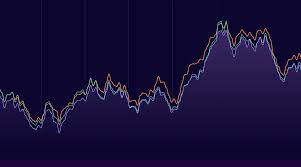

### What is Time Series

A **time series** is a data set that tracks a sample over time. 

**Forecasting** is the most common application of machine learning in the real world. 
For example, Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. 

### Things to Learn

- engineer features to model the major time series components (trends, seasons, and cycles),
- visualize time series with many kinds of time series plots,
- create forecasting hybrids that combine the strengths of complementary models, and
- adapt machine learning methods to a variety of forecasting tasks.


#### Loading Data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('./book_sales.csv', index_col ='Date', parse_dates =['Date']).drop('Paperback', axis = 1)

In [2]:
df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


**Data Information**

The number of hardcover book sales at a retail store over 30 days. Notice that we have a single column of observations `Hardcover` with a time index `Date`.

### Linear Regression with Time Series

Linear regression is widely used in practice and adapts naturally to even complex forecasting tasks. 

The **linear regression algorithm** learns how to make a weighted sum from its input features. For two features, we would have: 

```
target = weight_1 * feature_1 + weight_2 * feature_2 + bias
```

Two kinds of features unique to time series: **time-step features** and **lag features.**

#### Time-step features

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the `time dummy`, which counts off time steps in the series from beginning to end.


In [3]:
df['Time'] = np.arange(len(df.index))
df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


Linear regression with the time dummy produces the model: 

```
target = weight * time + bias
```

The time dummy then lets us fit curves to time series in a time plot, where `Time` forms the x-axis.

Text(0.5, 1.0, 'Time Plot of Hardcover Sales')

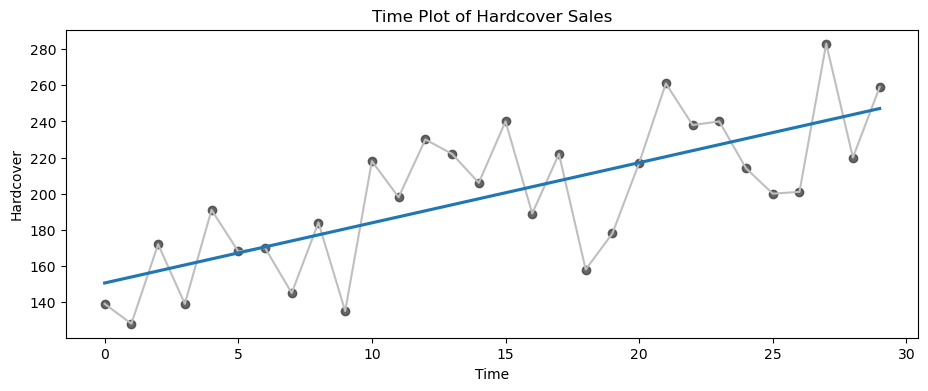

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(11,4))
plt.plot('Time', 'Hardcover', data=df, color='0.75')
sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
plt.title('Time Plot of Hardcover Sales')

Time-step features let you model **time dependence**. A series is time dependent if its values can be predicted from the time they occured.

#### Lag Features

To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [9]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Linear regression with a lag feature produces the model: 

```
target = weight * lag + bias
```

So lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.

Text(0.5, 1.0, 'Lag Plot of Hardcover Sales')

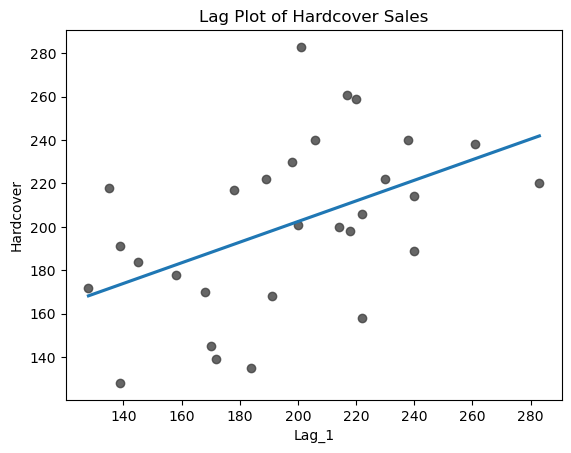

In [10]:
plt.figure()
sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
plt.title('Lag Plot of Hardcover Sales')

You can see from the lag plot that sales on one day (`Hardcover`) are correlated with sales from the previous day (`Lag_1`). When you see a relationship like this, you know a lag feature will be useful.

More generally, lag features let you model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations. 

-----------------------------------------------------------------------------------------

Adapting machine learning algorithms to time series problems is largely about feature engineering with the time index and lags

## Example : Tunnel Traffic

*Tunnel Traffic* is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005.

In [12]:
tunnel = pd.read_csv( "./tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day")
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


##### Time-step Feature

In [13]:
df = tunnel.copy()
df['Time'] = np.arange(len(df.index))
df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


The procedure for fitting a linear regression model follows the standard steps for scikit-learn.



In [14]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Time']]          #Feature
y = df.loc[:, 'NumVehicles']     #Target

model = LinearRegression().fit(X,y)

#Prediction
y_pred = pd.Series(model.predict(X), index = X.index)

The model actually created is (approximately): `Vehicles = 22.5 * Time + 98176`. Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

Text(0.5, 1.0, 'Time Plot of Tunnel Traffic')

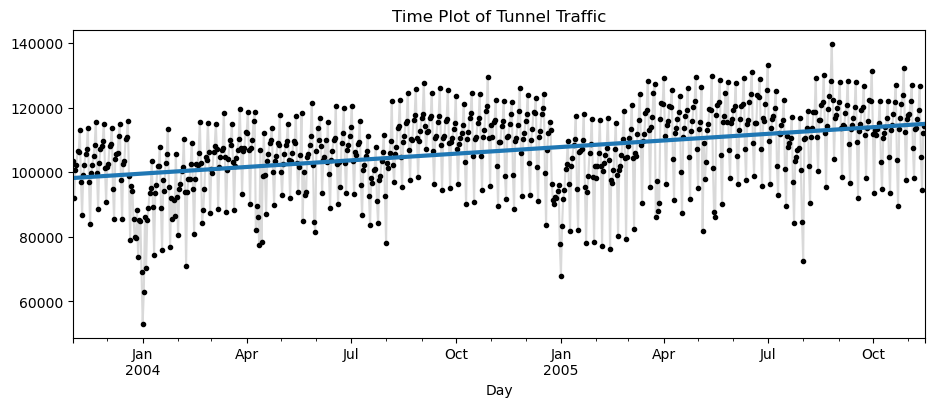

In [30]:
plt.figure(figsize=(11,4))
y.plot(color='0.85')
y.plot(style="o", color='black', ms=3)
y_pred.plot(linewidth=3)
plt.title('Time Plot of Tunnel Traffic')

#### Lag Features

Pandas provides us a simple method to lag a series, the `shift` method.



In [31]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [32]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

Text(0, 0.5, 'Number of Vehicles')

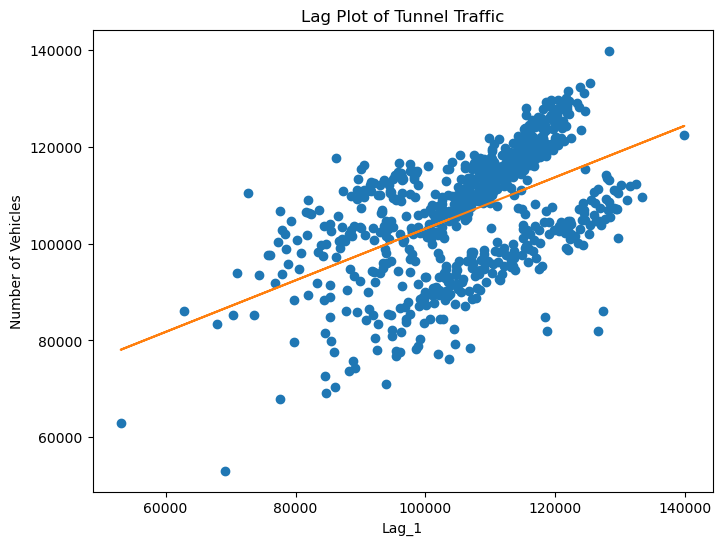

In [34]:
plt.figure(figsize=(8,6))
plt.plot(X['Lag_1'], y, 'o')
plt.plot(X['Lag_1'], y_pred)
plt.title('Lag Plot of Tunnel Traffic')
plt.xlabel('Lag_1')
plt.ylabel('Number of Vehicles')

The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

<Axes: xlabel='Day'>

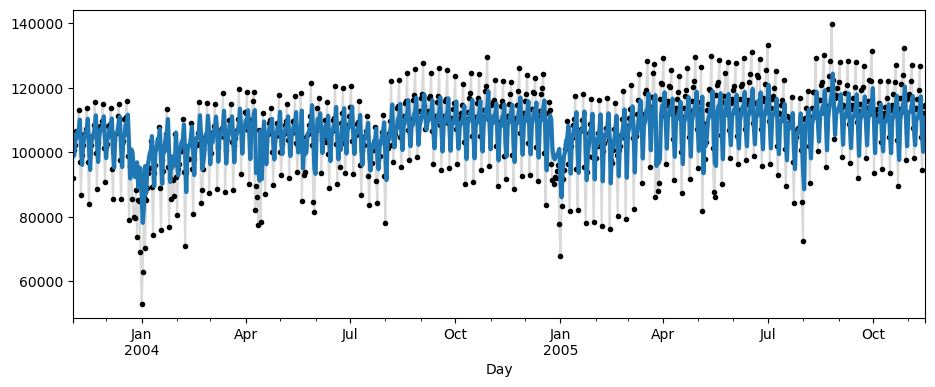

In [35]:
plt.figure(figsize=(11,4))
y.plot(color='0.85')
y.plot(style="o", color='black', ms=3)
y_pred.plot(linewidth=3)

The best time series models will usually include some combination of time-step features and lag features.